In [1]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [3]:
df

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1
...,...,...
6915,"painful , horrifying and oppressively tragic ,...",1
6916,take care is nicely performed by a quintet of ...,0
6917,"the script covers huge , heavy topics in a bla...",0
6918,a seriously bad film with seriously warped log...,0


In [4]:
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [5]:
from transformers import AutoTokenizer, DistilBertModel
import torch

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
input = df.iloc[0][0]
ids = tokenizer(input,add_special_tokens = True,return_tensors  = 'pt')
print(ids)
output = model(**ids)
last_layer = output.last_hidden_state
last_layer

{'input_ids': tensor([[  101,  1037, 18385,  1010,  6057,  1998,  2633, 18276,  2128, 16603,
          1997,  5053,  1998,  1996,  6841,  1998,  5687,  5469,  3152,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


tensor([[[-0.2159, -0.1403,  0.0083,  ..., -0.1369,  0.5867,  0.2011],
         [-0.2471,  0.2468,  0.1008,  ..., -0.1631,  0.9349, -0.0715],
         [ 0.0558,  0.3573,  0.4140,  ..., -0.2430,  0.1770, -0.5080],
         ...,
         [ 0.5113,  0.3471,  0.0273,  ...,  0.3259,  0.7047, -0.3381],
         [ 0.2807,  0.5242, -0.5708,  ...,  0.4081,  0.4943, -0.0218],
         [ 0.8637,  0.3259, -0.1457,  ...,  0.0325, -0.4152, -0.1499]]],
       grad_fn=<NativeLayerNormBackward0>)

In [7]:
tokenized = df[0].apply((lambda x: tokenizer(x,add_special_tokens = True,return_tensors  = 'pt',padding = True)))

In [8]:
tokenized[0]

{'input_ids': tensor([[  101,  1037, 18385,  1010,  6057,  1998,  2633, 18276,  2128, 16603,
          1997,  5053,  1998,  1996,  6841,  1998,  5687,  5469,  3152,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
# lis = []
# for ele in tokenized:
#     lis.append(len(ele['input_ids'][0]))
# max(lis)
max_leng = max([len(ele['input_ids'][0]) for ele in tokenized])
max_leng

67

In [10]:
for ele in tokenized.values:
    pad = torch.zeros(max_leng-len(ele['input_ids'][0])).int()
    temp = torch.cat((ele['input_ids'][0],pad),0)
    ele['input_ids'] = temp[None,:]
    temp = torch.cat((ele['attention_mask'][0],pad),0)
    ele['attention_mask'] = temp[None,:]

In [11]:
with torch.no_grad():
    last = model(**tokenized[0])
    last_h = last.last_hidden_state
    cls = last_h[0][0]
    for ind,ele in enumerate(tokenized):
        if ind==0:
            continue
        last = model(**ele)
        last_h = last.last_hidden_state
        cls = torch.vstack((cls,last_h[0][0]))
        if ind%100 == 0:
            print(ind)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


In [12]:
cls.shape, cls

(torch.Size([6920, 768]),
 tensor([[-0.2159, -0.1403,  0.0083,  ..., -0.1369,  0.5867,  0.2011],
         [-0.1726, -0.1448,  0.0022,  ..., -0.1744,  0.2139,  0.3720],
         [-0.0506,  0.0720, -0.0296,  ..., -0.0715,  0.7185,  0.2623],
         ...,
         [-0.0655, -0.0518, -0.1409,  ..., -0.0645,  0.6022,  0.2135],
         [-0.0852, -0.0487, -0.0814,  ..., -0.1359,  0.3951,  0.2289],
         [-0.2944, -0.0923, -0.0083,  ..., -0.0516,  0.4350,  0.2889]]))

In [25]:
cls1 = cls[:,0:64]

In [26]:
features = cls1.numpy()
features,features.shape

(array([[-2.15934366e-01, -1.40289009e-01,  8.31084698e-03, ...,
         -1.76843256e-02,  8.29957426e-03, -7.89425150e-02],
        [-1.72627255e-01, -1.44761652e-01,  2.23429501e-03, ...,
         -1.13198712e-01, -3.02073002e-01,  1.03078835e-01],
        [-5.06334789e-02,  7.20397234e-02, -2.95971930e-02, ...,
          3.48314553e-01, -1.03250854e-01,  1.39722489e-02],
        ...,
        [-6.55093715e-02, -5.18473834e-02, -1.40944526e-01, ...,
         -1.05139226e-01, -2.55439132e-01,  4.75293305e-03],
        [-8.52313936e-02, -4.86979857e-02, -8.13752115e-02, ...,
         -1.04775235e-01,  1.19313598e-04, -9.26723108e-02],
        [-2.94368267e-01, -9.23467800e-02, -8.31665099e-03, ...,
          7.67309368e-02, -6.82395175e-02, -1.05146199e-01]], dtype=float32),
 (6920, 64))

In [27]:
labels = df[1]
labels

0       1
1       0
2       0
3       1
4       1
       ..
6915    1
6916    0
6917    0
6918    0
6919    1
Name: 1, Length: 6920, dtype: int64

In [28]:
train_ft,test_ft, train_lb, test_lb = train_test_split(features,labels)

In [29]:
lr_clf = LogisticRegression()
lr_clf.fit(train_ft, train_lb)

LogisticRegression()

In [30]:
lr_clf.score(test_ft,test_lb)

0.7901734104046243

In [23]:
n1 = int(0.8*len(cls))
n1

5536

In [24]:
n1 = int(0.8*len(cls))
Xtr,Ytr = cls[:n1],labels[:n1]
Xte, Yte = cls[n1:],labels[n1:]

In [86]:
layers = [torch.nn.Linear(768,2,True)]
param = [p for p in layer.parameters()]
print(sum(p.nelement() for p in param))
for p in param:
    p.requires_grad = True

1538


In [82]:
import torch.nn
import torch.nn.functional as F


lossi = []
count  = 0
for x,y in zip(Xtr,Ytr):
    count +=1
    
    # forward pass 
    out = layer(x)
    ypred = torch.sigmoid(out)
    y = torch.tensor(y).float()
    bce = torch.nn.BCELoss()
    loss = bce(ypred[0],y)
    lossi.append(loss.item())
    
    # backward pass
    loss.backward()
    
    #update rule
    lr = 0.01
    for p in param:
        p.data += -lr*p.grad
    if(count%300==0):
        print(f'loss at {count}/{len(Xtr)} is {loss.item()}')


loss at 300/5536 is 100.0
loss at 600/5536 is 100.0
loss at 900/5536 is 0.0
loss at 1200/5536 is 0.0
loss at 1500/5536 is 0.0
loss at 1800/5536 is 0.0
loss at 2100/5536 is 0.0
loss at 2400/5536 is 100.0
loss at 2700/5536 is 100.0
loss at 3000/5536 is 0.0
loss at 3300/5536 is 100.0
loss at 3600/5536 is 0.0
loss at 3900/5536 is 100.0
loss at 4200/5536 is 100.0
loss at 4500/5536 is 100.0
loss at 4800/5536 is 100.0
loss at 5100/5536 is 0.0
loss at 5400/5536 is 100.0


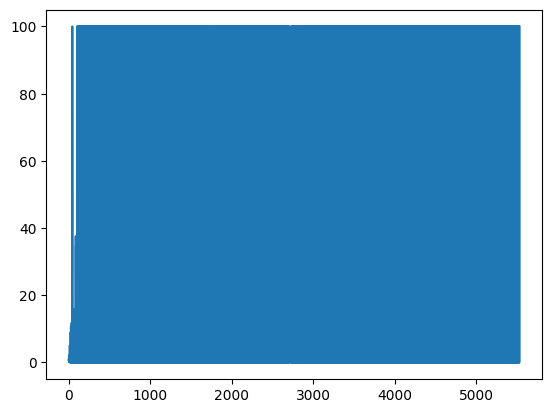

In [83]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(0,5536),lossi)

In [84]:
match = 0
with torch.no_grad():
    for x,y in zip(Xte,Yte):
        out = layer(x)
        ypred = F.softmax(out).int()
        print(ypred)
        if ypred[0].item() == y:
            match += 1 
print("Accuracy:",match/len(Yte))
    

C:\Users\SriRa\AppData\Local\Temp\ipykernel_29864\1072835540.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(out).int()


tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([

tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([1], dtype=torch.int32)
tensor([